In [ ]:
from datetime import datetime as dt
import os
import pandas as pd
import re

import ark.mibi.qc_comp as qc_comp
import ark.utils.io_utils as io_utils

### Define parameters for MIBItracker download

Define the following MIBItracker parameters:

* `email`/`password`: your login info to MIBItracker
* `run_name`/`run_label`: this info can be extracted from the desired run page on MIBItracker

In [ ]:
# set MIBItracker specific parameters
email = 'qc.mibi@gmail.com'
password = 'The_MIBI_Is_Down_Again1!?'
run_name = '191008_JG85b'
run_label = 'JG85_Run2'

Define the following paths:

* `base_dir`: where the created image directory (`tiff_dir`) will be placed
* `tiff_dir`: the name of the image directory to store the MIBItracker download. If `None`, set equal to `{datetime_at_start_of_run}_{run_name}`
* `img_sub_folder`: if you wish to specify an additional subfolder within each FOV folder to store the images. Set to `None` if you do not want one.

In [ ]:
# set info related
base_dir = '../data/example_dataset'
tiff_dir = None
img_sub_folder = "TIFs"

# set tiff_dir based on datetime if not specified
if tiff_dir is None:
    tiff_dir = dt.now().strftime('%Y_%m_%d') + '_%s' % run_name

Define the following subsets if desired:

* `fovs`: a subset of FOVs to use from the run. If `None`, uses all of them.
* `channels`: a subset of channels to use from the run. If `None`, uses all of them.

In [ ]:
fovs = None
channels = None

### Download data off MIBItracker

This downloads the MIBItracker data and returns the run acquisition order the FOVs were prorcessed in.

Note: set the `overwrite_tiff_dir` param to `True` if `tiff_dir` already exists and you want to overwrite the data in it.

In [ ]:
run_order = qc_comp.download_mibitracker_data(
    email,
    password,
    run_name,
    run_label,
    base_dir,
    tiff_dir=tiff_dir,
    overwrite_tiff_dir=False,
    img_sub_folder=img_sub_folder,
    fovs=fovs,
    channels=channels
)

### Define parameters for QC metric analysis

Set the following parameters for Gaussian blurring prior to running QC metric analysis:

* `gaussian_blur`: set to `True` if a Gaussian blur is desired
* `blur_factor`: define the standard deviation of the Gaussian kernel. Higher values are more aggressive in smoothing signal. Ignored if `gaussian_blur` is `False`.

In [ ]:
gaussian_blur = False
blur_factor = 1

### Create QC metric tables

In [ ]:
qc_data = qc_comp.compute_qc_metrics(
    os.path.join(base_dir, tiff_dir),
    img_sub_folder=img_sub_folder,
    fovs=fovs,
    channels=channels,
    batch_size=5,
    gaussian_blur=gaussian_blur,
    blur_factor=blur_factor
)

In [ ]:
# extract the individual DataFrames from qc_data
df_nonzero_mean = qc_data['nonzero_mean']
df_total_intensity = qc_data['total_intensity']
df_99_9_intensity = qc_data['99_9_intensity']

In [ ]:
# sort each QC metric table by run acquisition
sort_function = lambda row: dict(run_order)[row['fov']]

df_nonzero_mean['fov'] = df_nonzero_mean.apply(sort_function, axis=1).astype(int)
df_total_intensity['fov'] = df_total_intensity.apply(sort_function, axis=1).astype(int)
df_99_9_intensity['fov'] = df_99_9_intensity.apply(sort_function, axis=1).astype(int)

In [ ]:
# sort the data by increasing fov number (for visualization, assumes fov numbers are in run order)
df_nonzero_mean = df_nonzero_mean.sort_values(by='fov')
df_total_intensity = df_total_intensity.sort_values(by='fov')
df_99_9_intensity = df_99_9_intensity.sort_values(by='fov')

In [ ]:
# save the QC metric values
df_nonzero_mean.to_csv(os.path.join(base_dir, 'nonzero_mean_stats.csv'), index=False)
df_total_intensity.to_csv(os.path.join(base_dir, 'total_intensity_stats.csv'), index=False)
df_99_9_intensity.to_csv(os.path.join(base_dir, 'percentile_99_9_stats.csv'), index=False)

### Visualize QC metrics

Note: the x-axis (FOV labels) of each graph is ordered in the FOV acquisition order

In [ ]:
# melt the DataFrames for visualization
df_nonzero_mean_melt = pd.melt(df_nonzero_mean, id_vars=['fov'], value_vars=channels, var_name='channel', value_name='Non-zero mean intensity')
df_total_intensity_melt = pd.melt(df_total_intensity, id_vars=['fov'], value_vars=channels, var_name='channel', value_name='Total intensity')
df_99_9_intensity_melt = pd.melt(df_99_9_intensity, id_vars=['fov'], value_vars=channels, var_name='channel', value_name='99.9% intensity value')

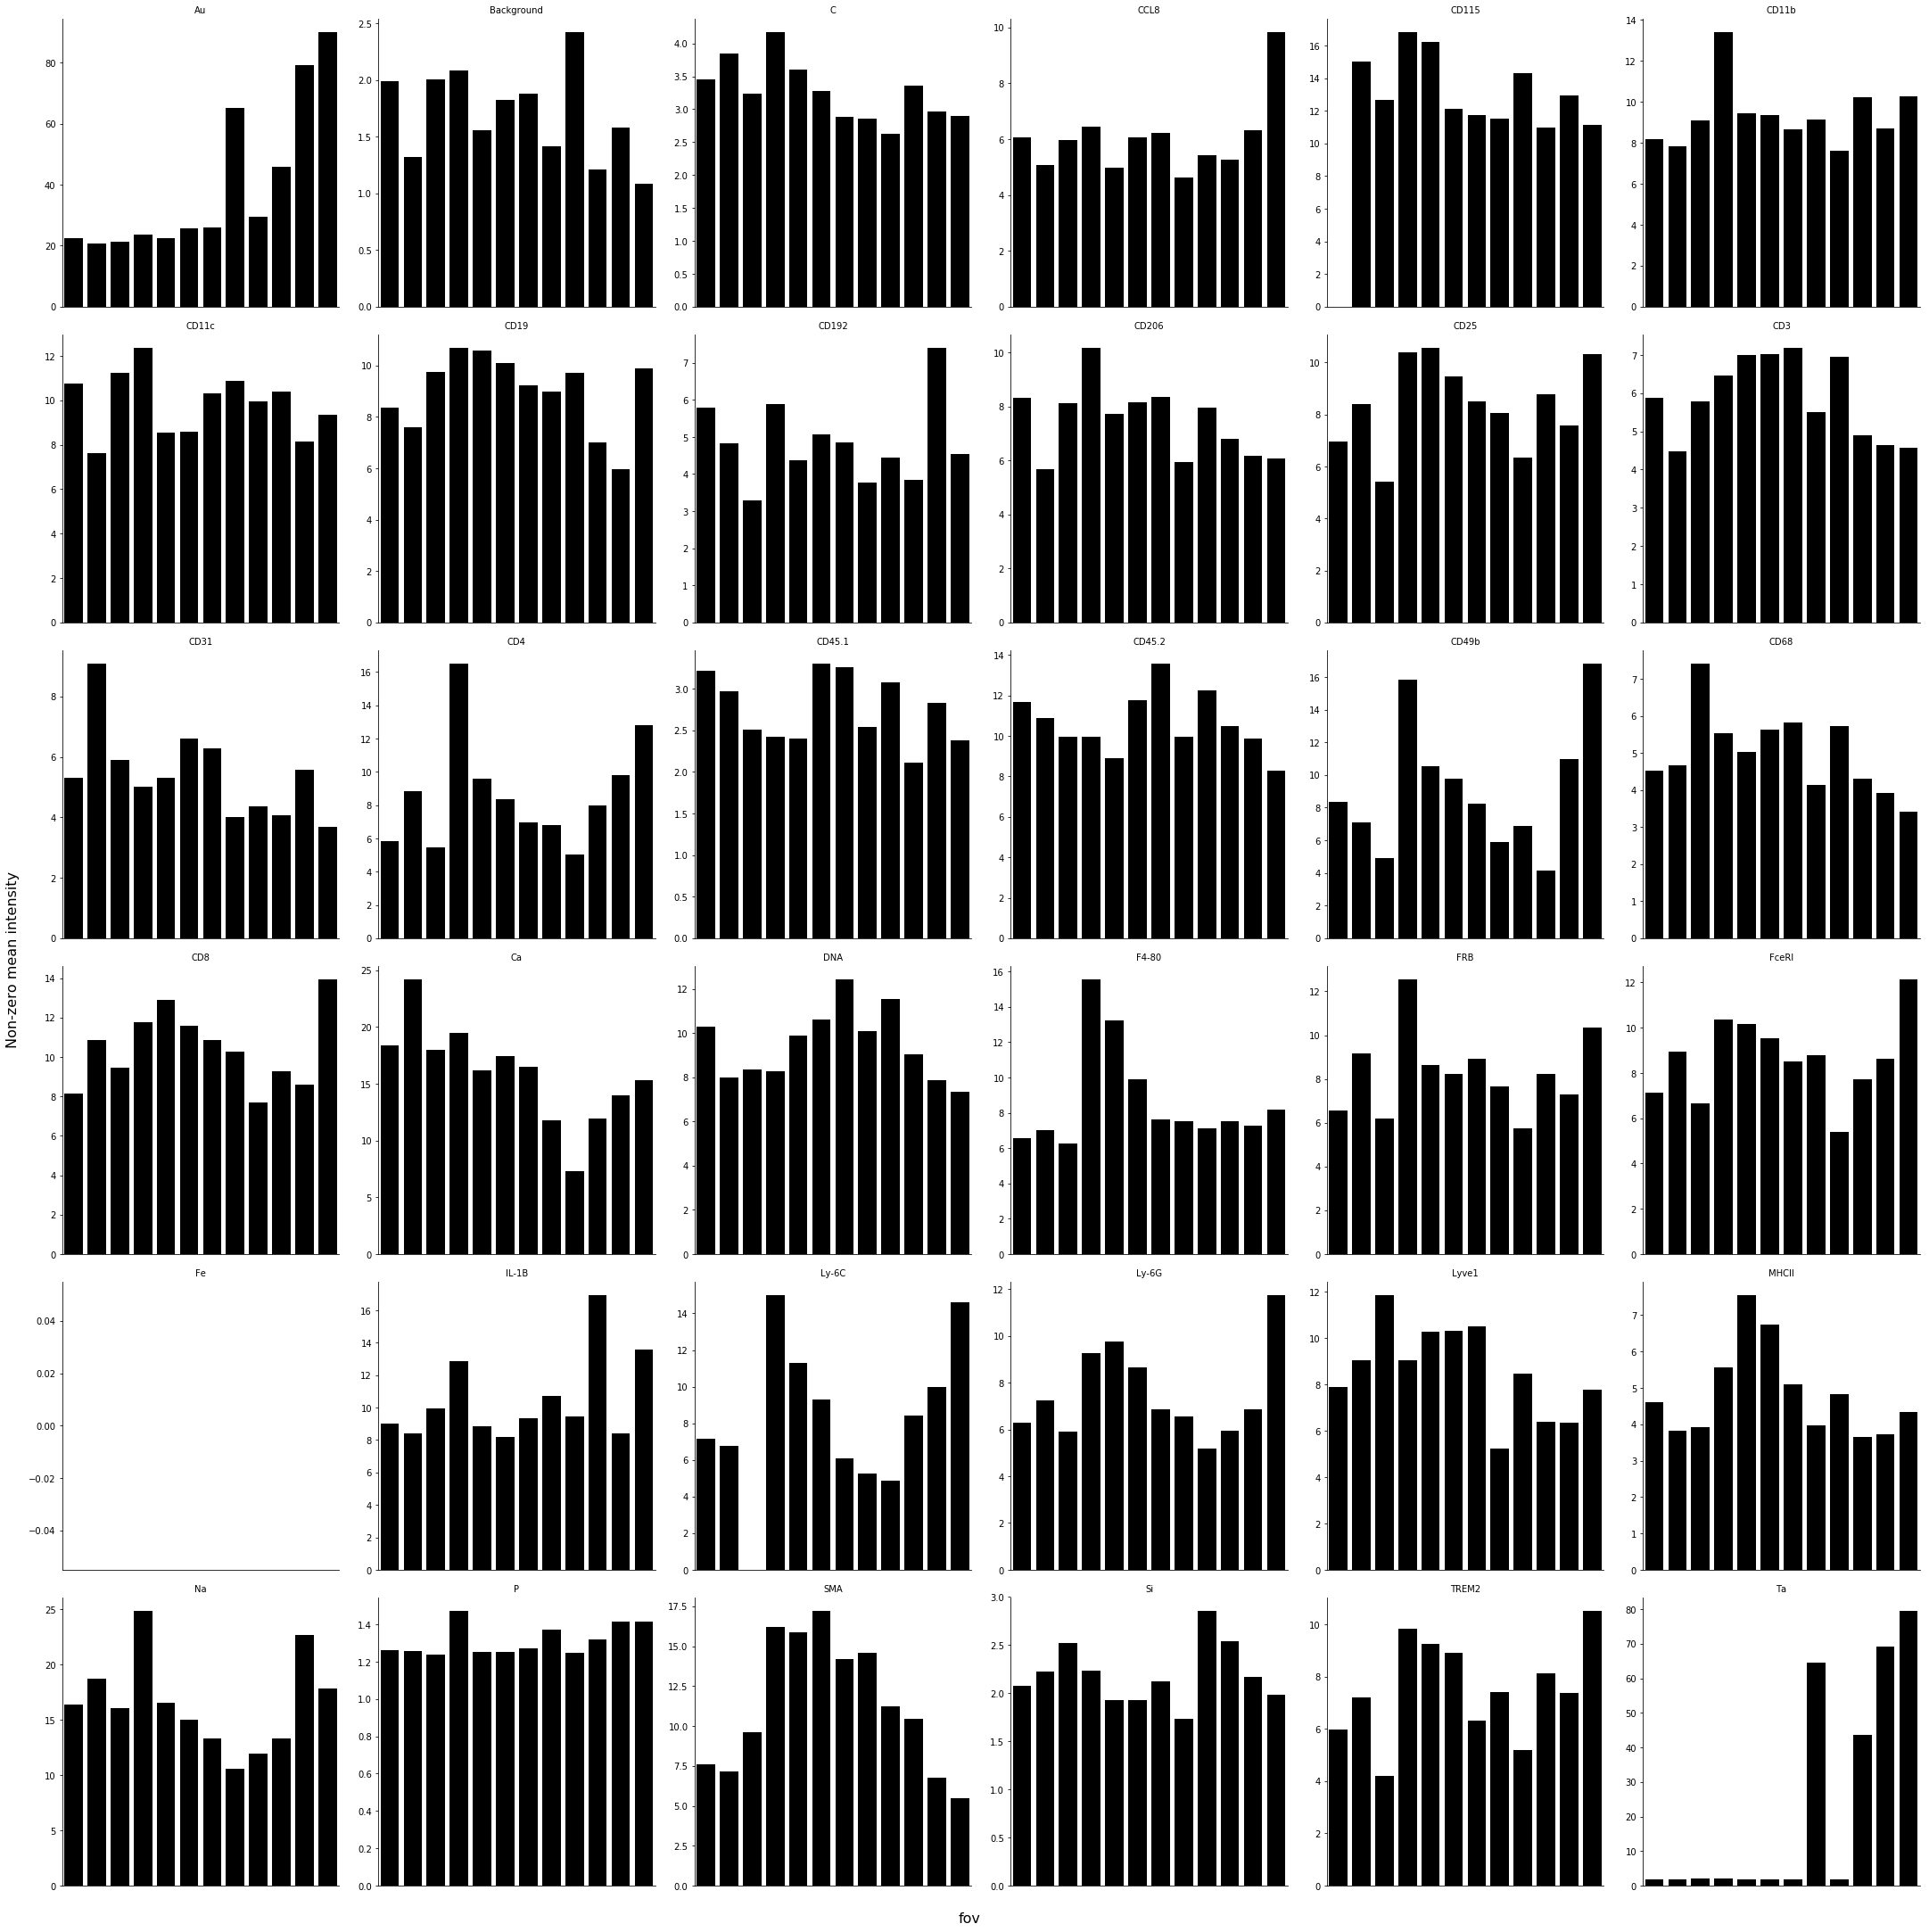

In [13]:
# visualize the non-zero mean intensity stats
qc_comp.visualize_qc_metrics(
    df_nonzero_mean_melt,
    'Non-zero mean intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)

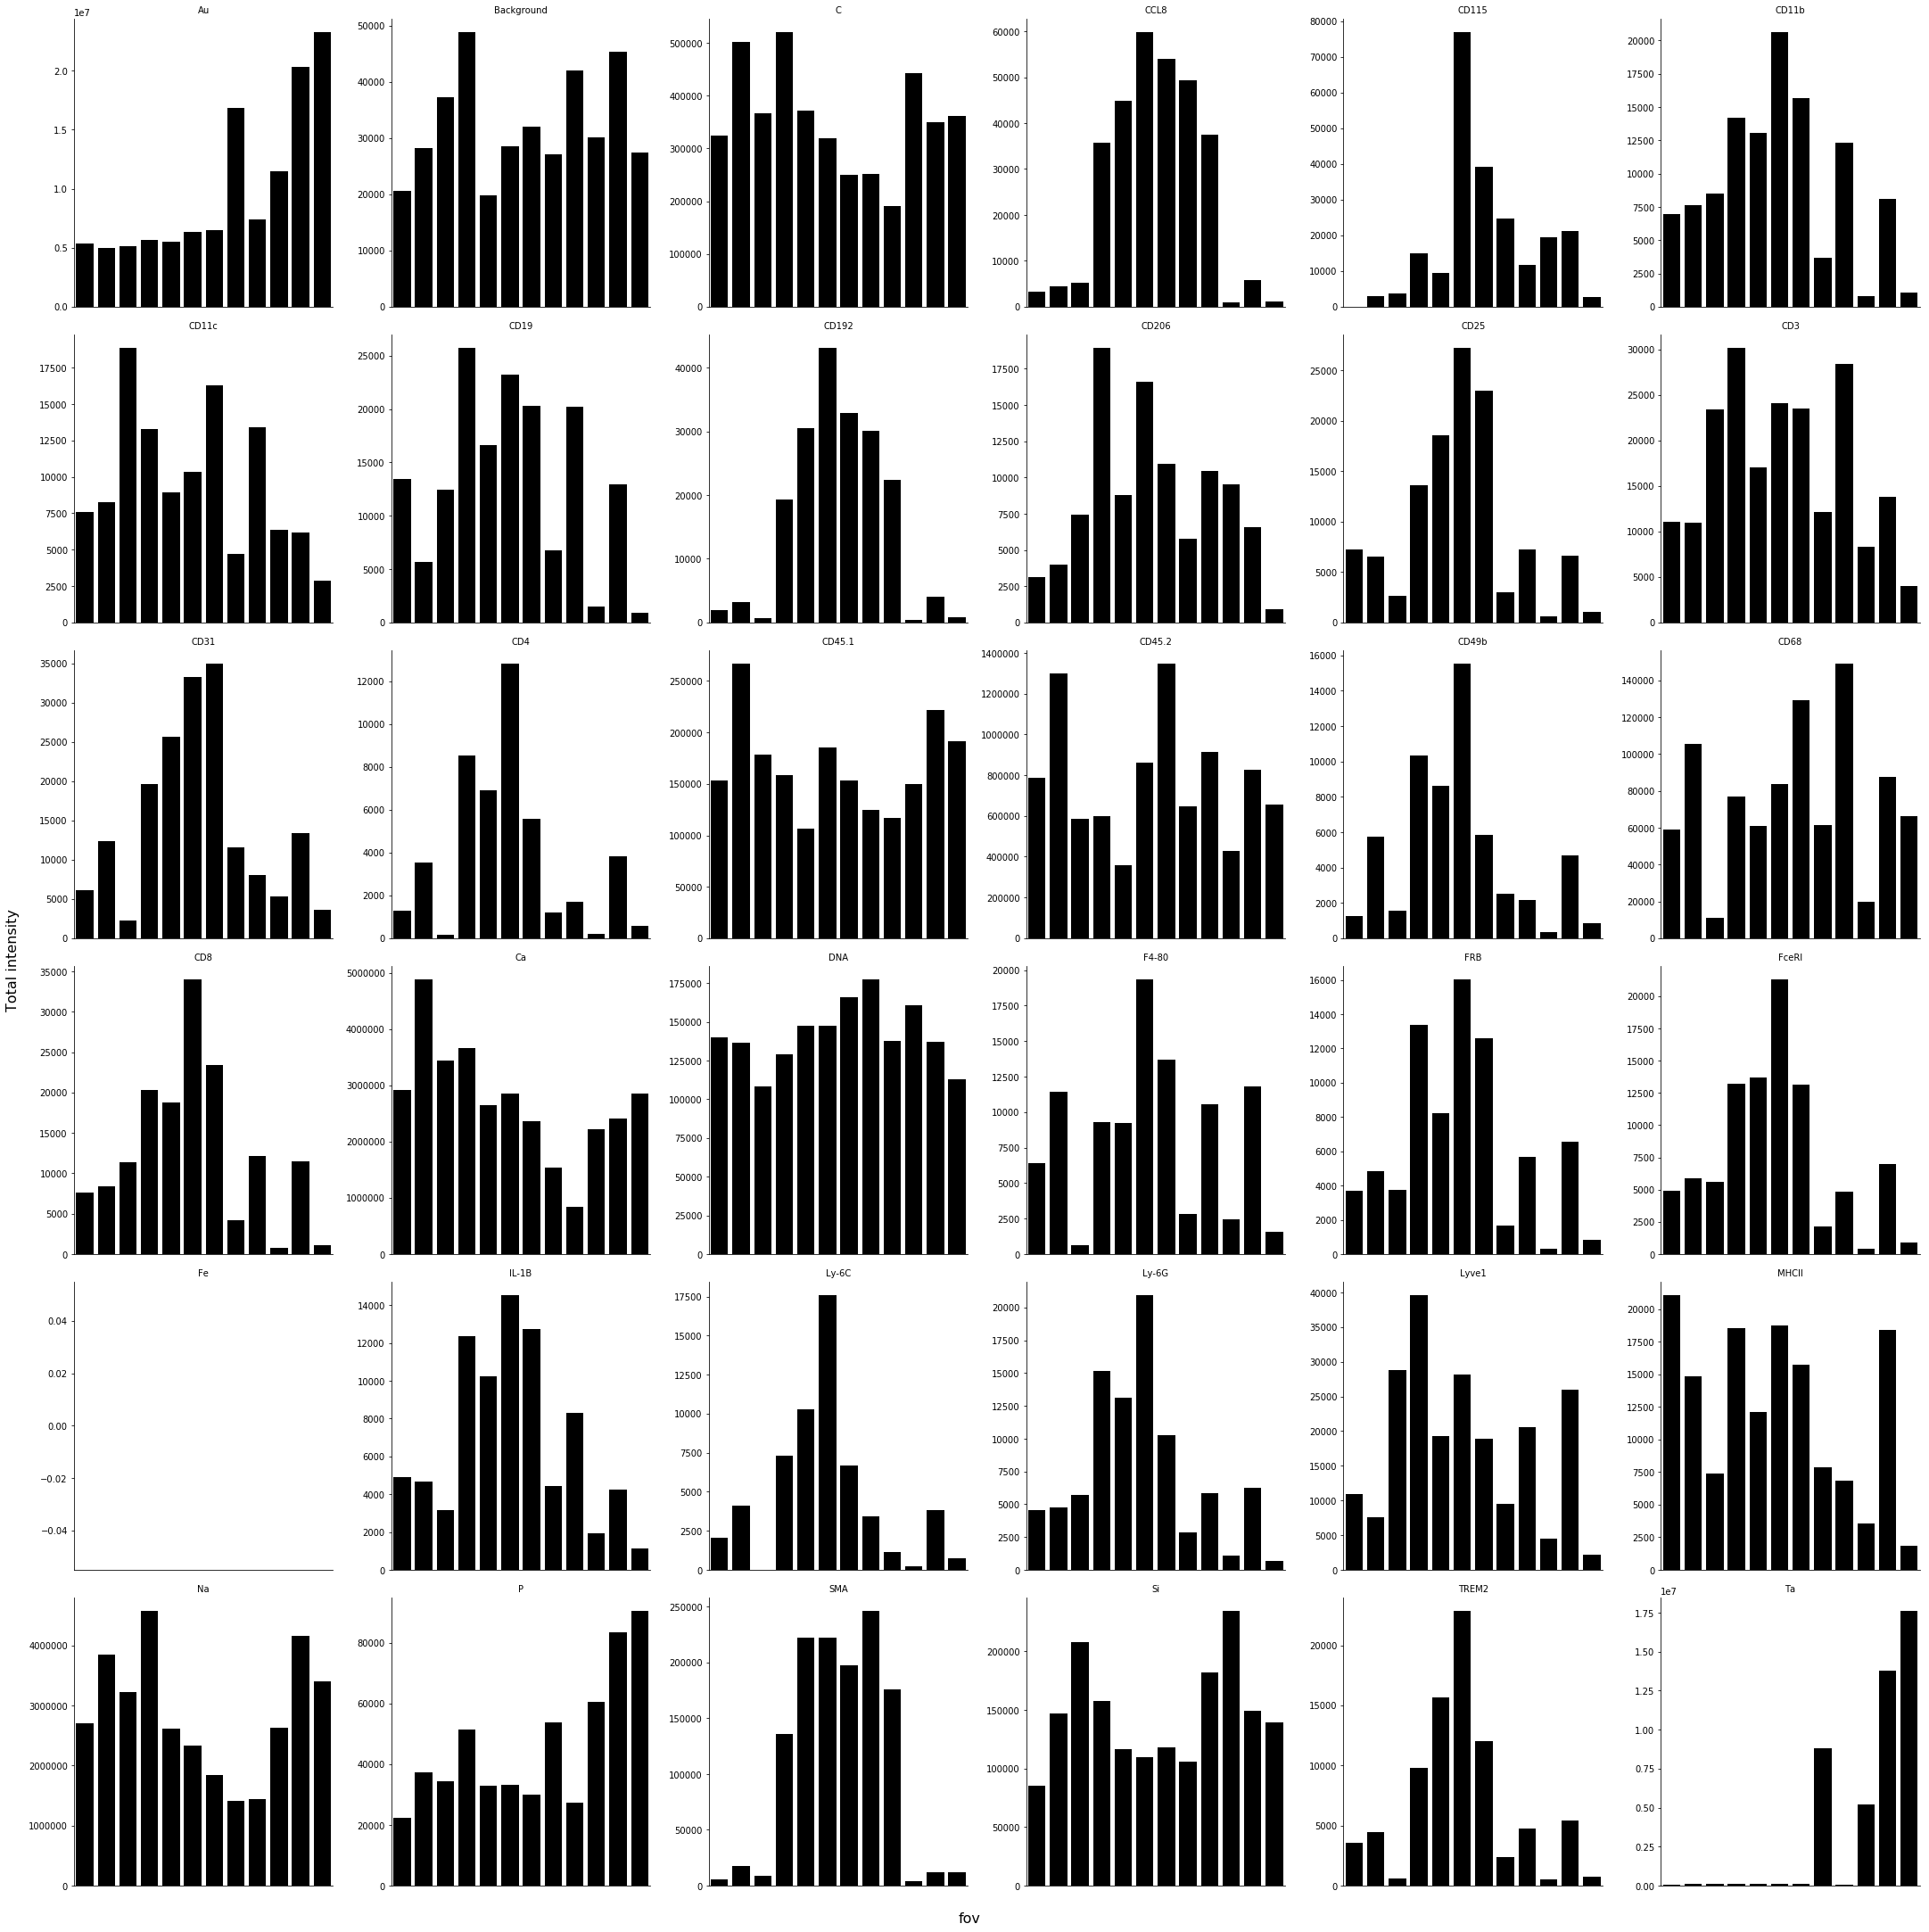

In [14]:
# visualize the total intensity stats
qc_comp.visualize_qc_metrics(
    df_total_intensity_melt,
    'Total intensity',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)

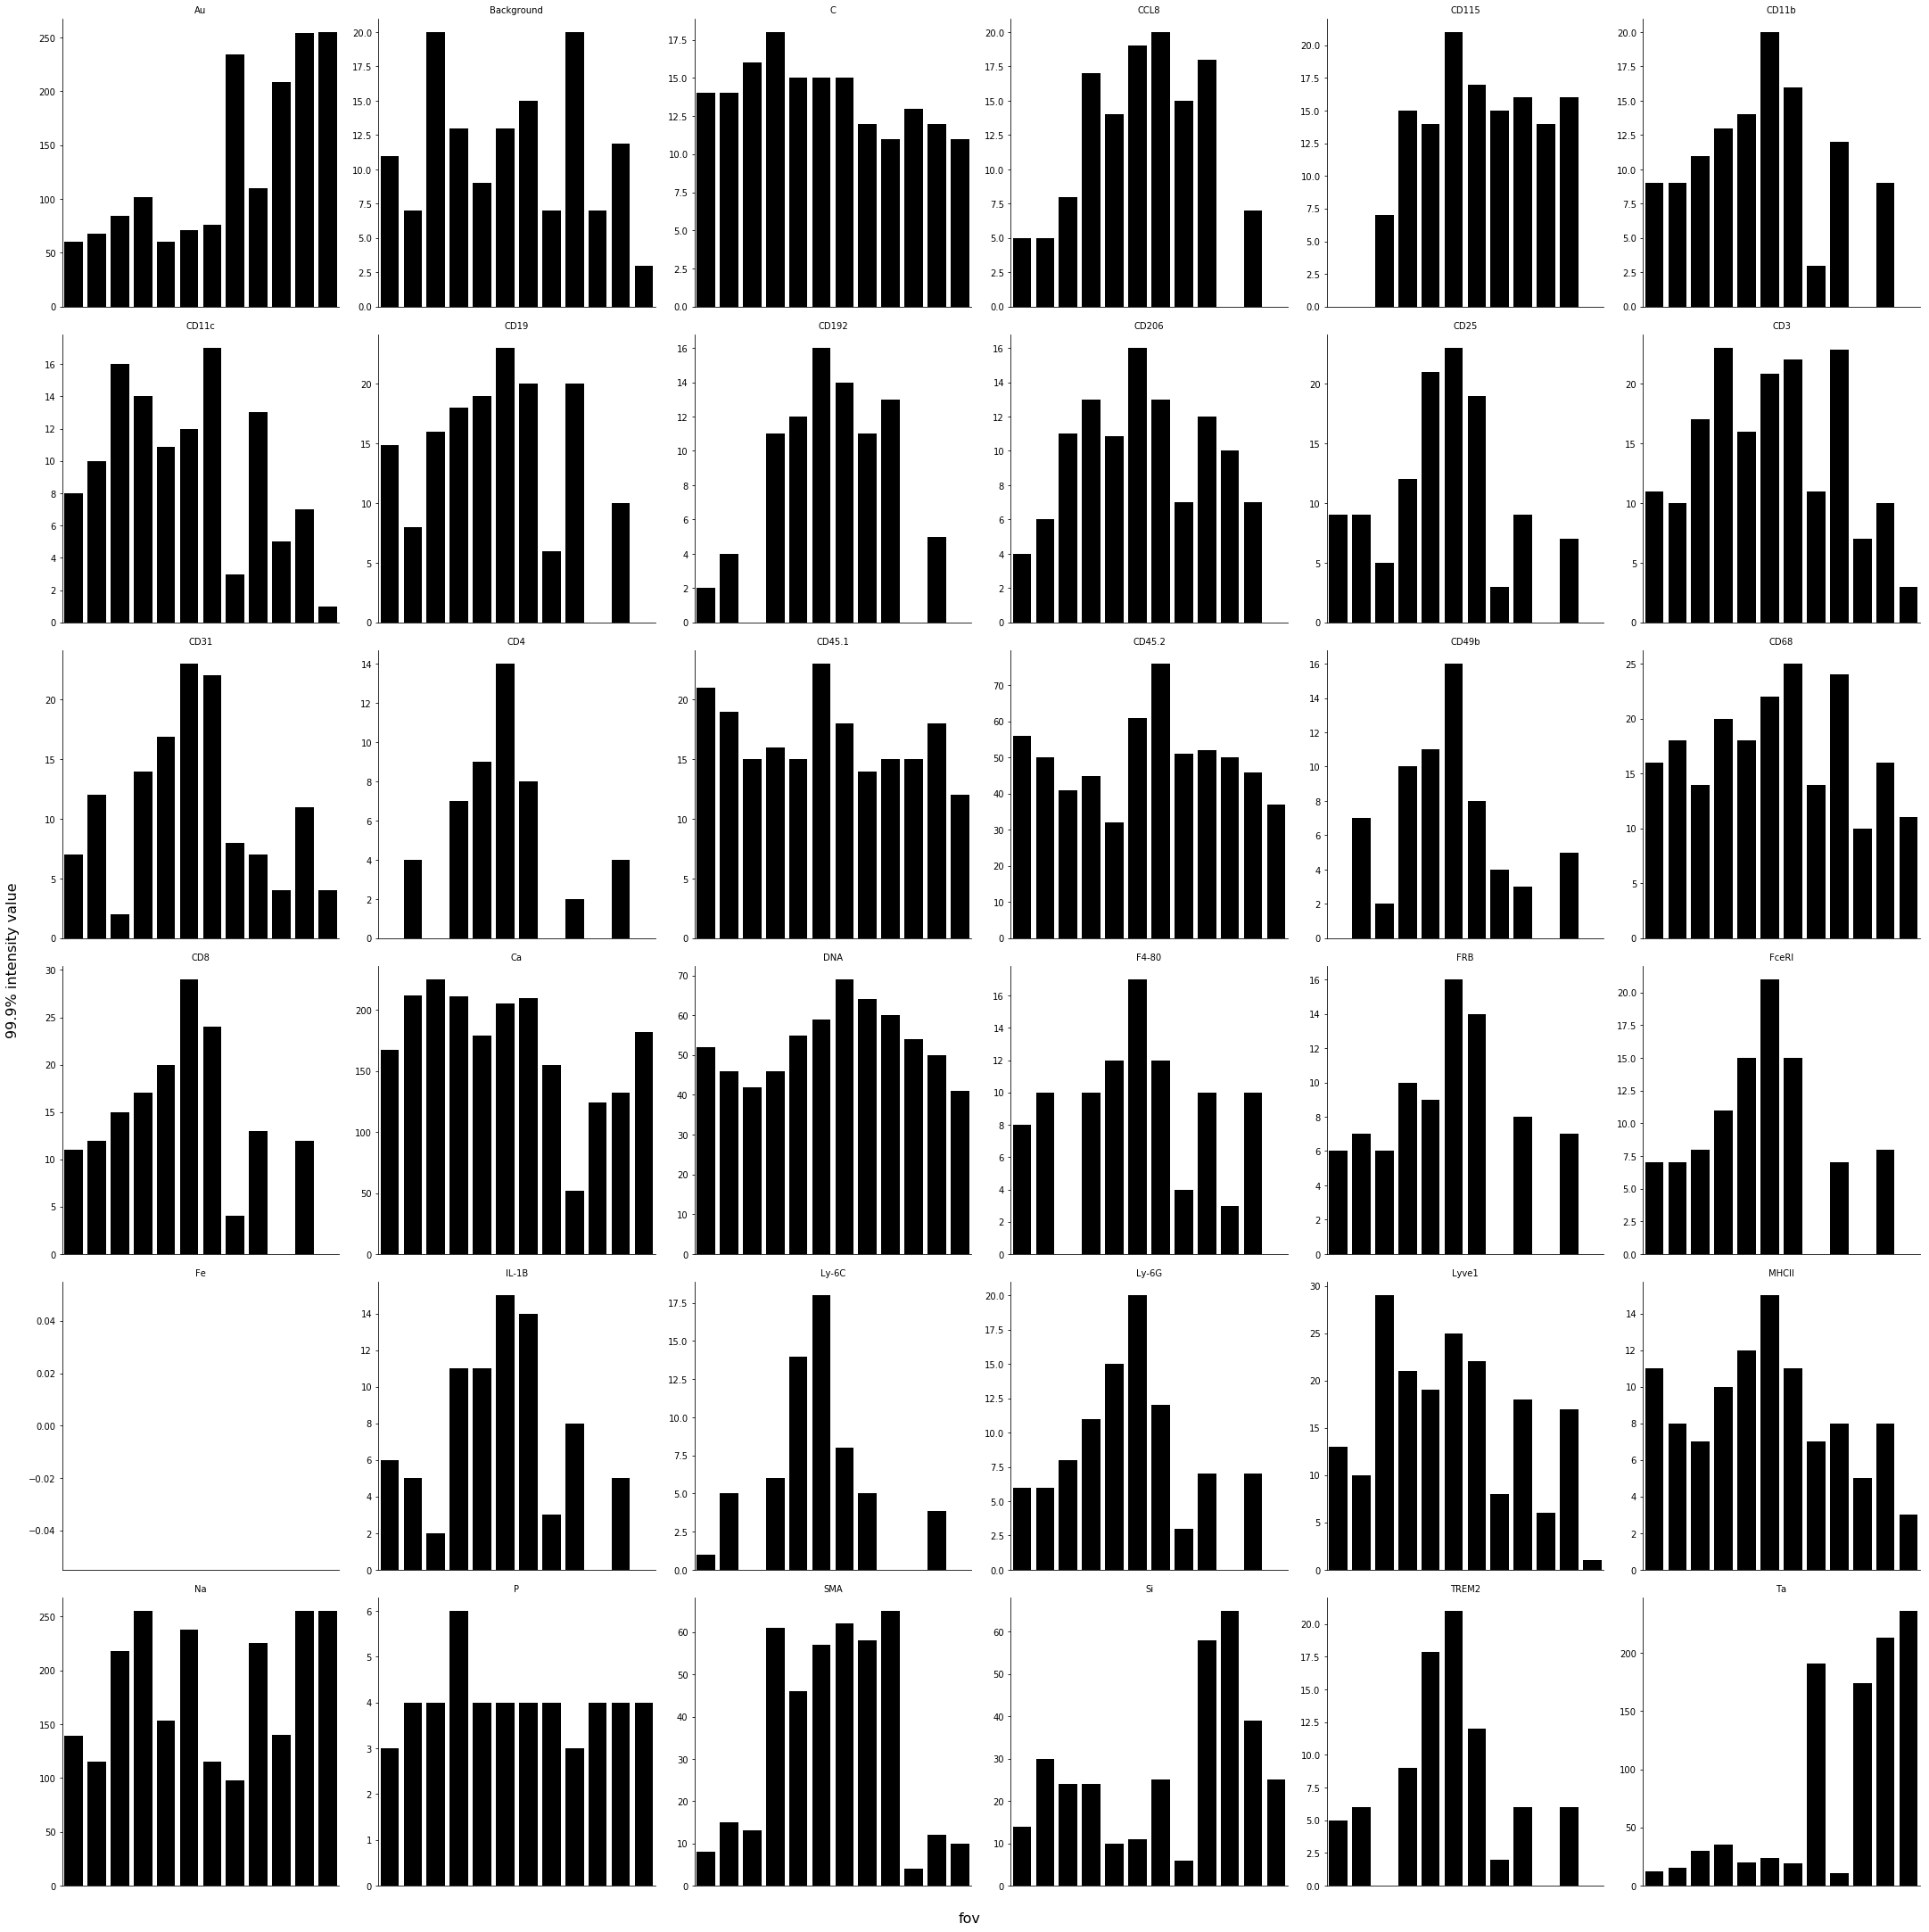

In [15]:
# visualize the 99.9% intensity value stats
qc_comp.visualize_qc_metrics(
    df_99_9_intensity_melt,
    '99.9% intensity value',
    axes_size=16,
    wrap=6,
    dpi=None,
    save_dir=None
)